In [348]:
import pandas as pd
import math
from IPython.display import Image
from IPython.core.display import HTML 


# Assignment 1 

## Question 1: Sign up email

## Question 2: Reflections

Write one thing that you really enjoyed learning about in the first week of class. Write one
thing where you felt there was a learning gap. Write how much time it took for you to do
the assignment, and attribute any sources or people you discussed with. Please be as specific
as possible. 

(3 pts.)

I really liked learning about the different assumptions 
that population geneticists use. I learned that the Wright Fisher model abstracts the shape of human DNA and the replication process to create a simpler model which can be expanded upon later. The Infinite sites assumption is also very important which at first I was not sure how we would use. 

For my learning gap. I would say the linkage disequilibrium needs some work. I understand the concepts of LD but I really need to work on the mathematics. 

The assignment took me about 20 hours. 

Citations
- For question 3: https://en.wikipedia.org/wiki/Hardy%E2%80%93Weinberg_principle#Generalization_for_more_than_two_alleles
- I also asked Jens a couple of questions that had to do with the lecture on phylogeny. There are many assumptions that I also     wanted to clarify like the ones made by the Wright Fisher Model. 


## Question 3: Wheat Bread

The so called ‘bread wheat’ is hexaploid (6 copies of each chromsome). 

Consider a locus with 4 allelic values (a, b, c, d) with frequencies 0.5, 0.25, 0.15, 0.1, respectively. 

(a) Compute the number of distinct possible genotypes. 

(b) Compute the expected number of occurrences of the genotype ab^3c^2 in a sample of 10, 000 individuals, assuming HW equilibrium
holds 

(c) Generalize part (a) to compute the number of distinct genotypes given a ploidy of
n (n copies of each chromosome) and m alleles.
(8 pts)


In [244]:
import operator as op
from scipy.misc import comb
import numpy as np

In [245]:
# The set made by choosing an allele for every chromosome is not a permutation. It's a combination because different orders
# of the allele don't matter. DONE
a_genos = comb(6 + 4 - 1, 4)

In [246]:
# Need to include a combinatorics coefficient to this to account for all the combinations. Currently this calculation
# is only focused on a permutation. 
b_occurences = 0.5 * (0.25**3) * (0.15**2) * 0.1 * 10000 * a_genos 

In [247]:
# Basically the binomial distribution. 
c_general_genos = '(n + m - 1) choose m'

In [248]:
print 'a) {}'.format(a_genos)
print 'b) {}'.format(b_occurences)
print 'c) {}'.format(c_general_genos)

a) 126.0
b) 22.1484375
c) (n + m - 1) choose m


## Question 4: Diploid Population Tool

Consider a diploid population with 4 alleles A1, A2, A3, A4 at a locus. An experiment
on 100 individuals revealed the following counts of heterozygous individuals.

(Table below)

Design and implement a tool that estimates the most likely allele frequencies in the population,
assuming HWE is satisfied.

In [73]:
data = [[0, 18, 21, 12], [0, 0, 7, 3], [0, 0, 0, 5]]

In [252]:
def estimate_het_tetraploidy_frequencies(data):
    rows = ['A1', 'A2', 'A3']
    columns = ['A1', 'A2', 'A3', 'A4']
    dataframe = pd.DataFrame(data=data, index=rows, columns=columns)
    dataframe = dataframe.applymap(lambda x: float(x)/100)
    a1 = np.sqrt(dataframe.ix['A1', 'A2'] * dataframe.ix['A1', 'A3'] / (dataframe.ix['A2', 'A3'] * 2))
    a2 = dataframe.ix['A1', 'A2'] / (2 * a1)
    a3 = dataframe.ix['A1', 'A3'] / (2 * a1)
    a4 = dataframe.ix['A1', 'A4'] / (2 * a1)
    return a1, a2, a3, a4

In [253]:
a1, a2, a3, a4 = estimate_het_tetraploidy_frequencies(data)

In [254]:
print 'The frequency of A1 is {}, A2 {}, A3 {}, A4 {}'.format(a1, a2, a3, a4)

The frequency of A1 is 0.519615242271, A2 0.173205080757, A3 0.202072594216, A4 0.115470053838


## Question 5: Hardy Weinburg Graph

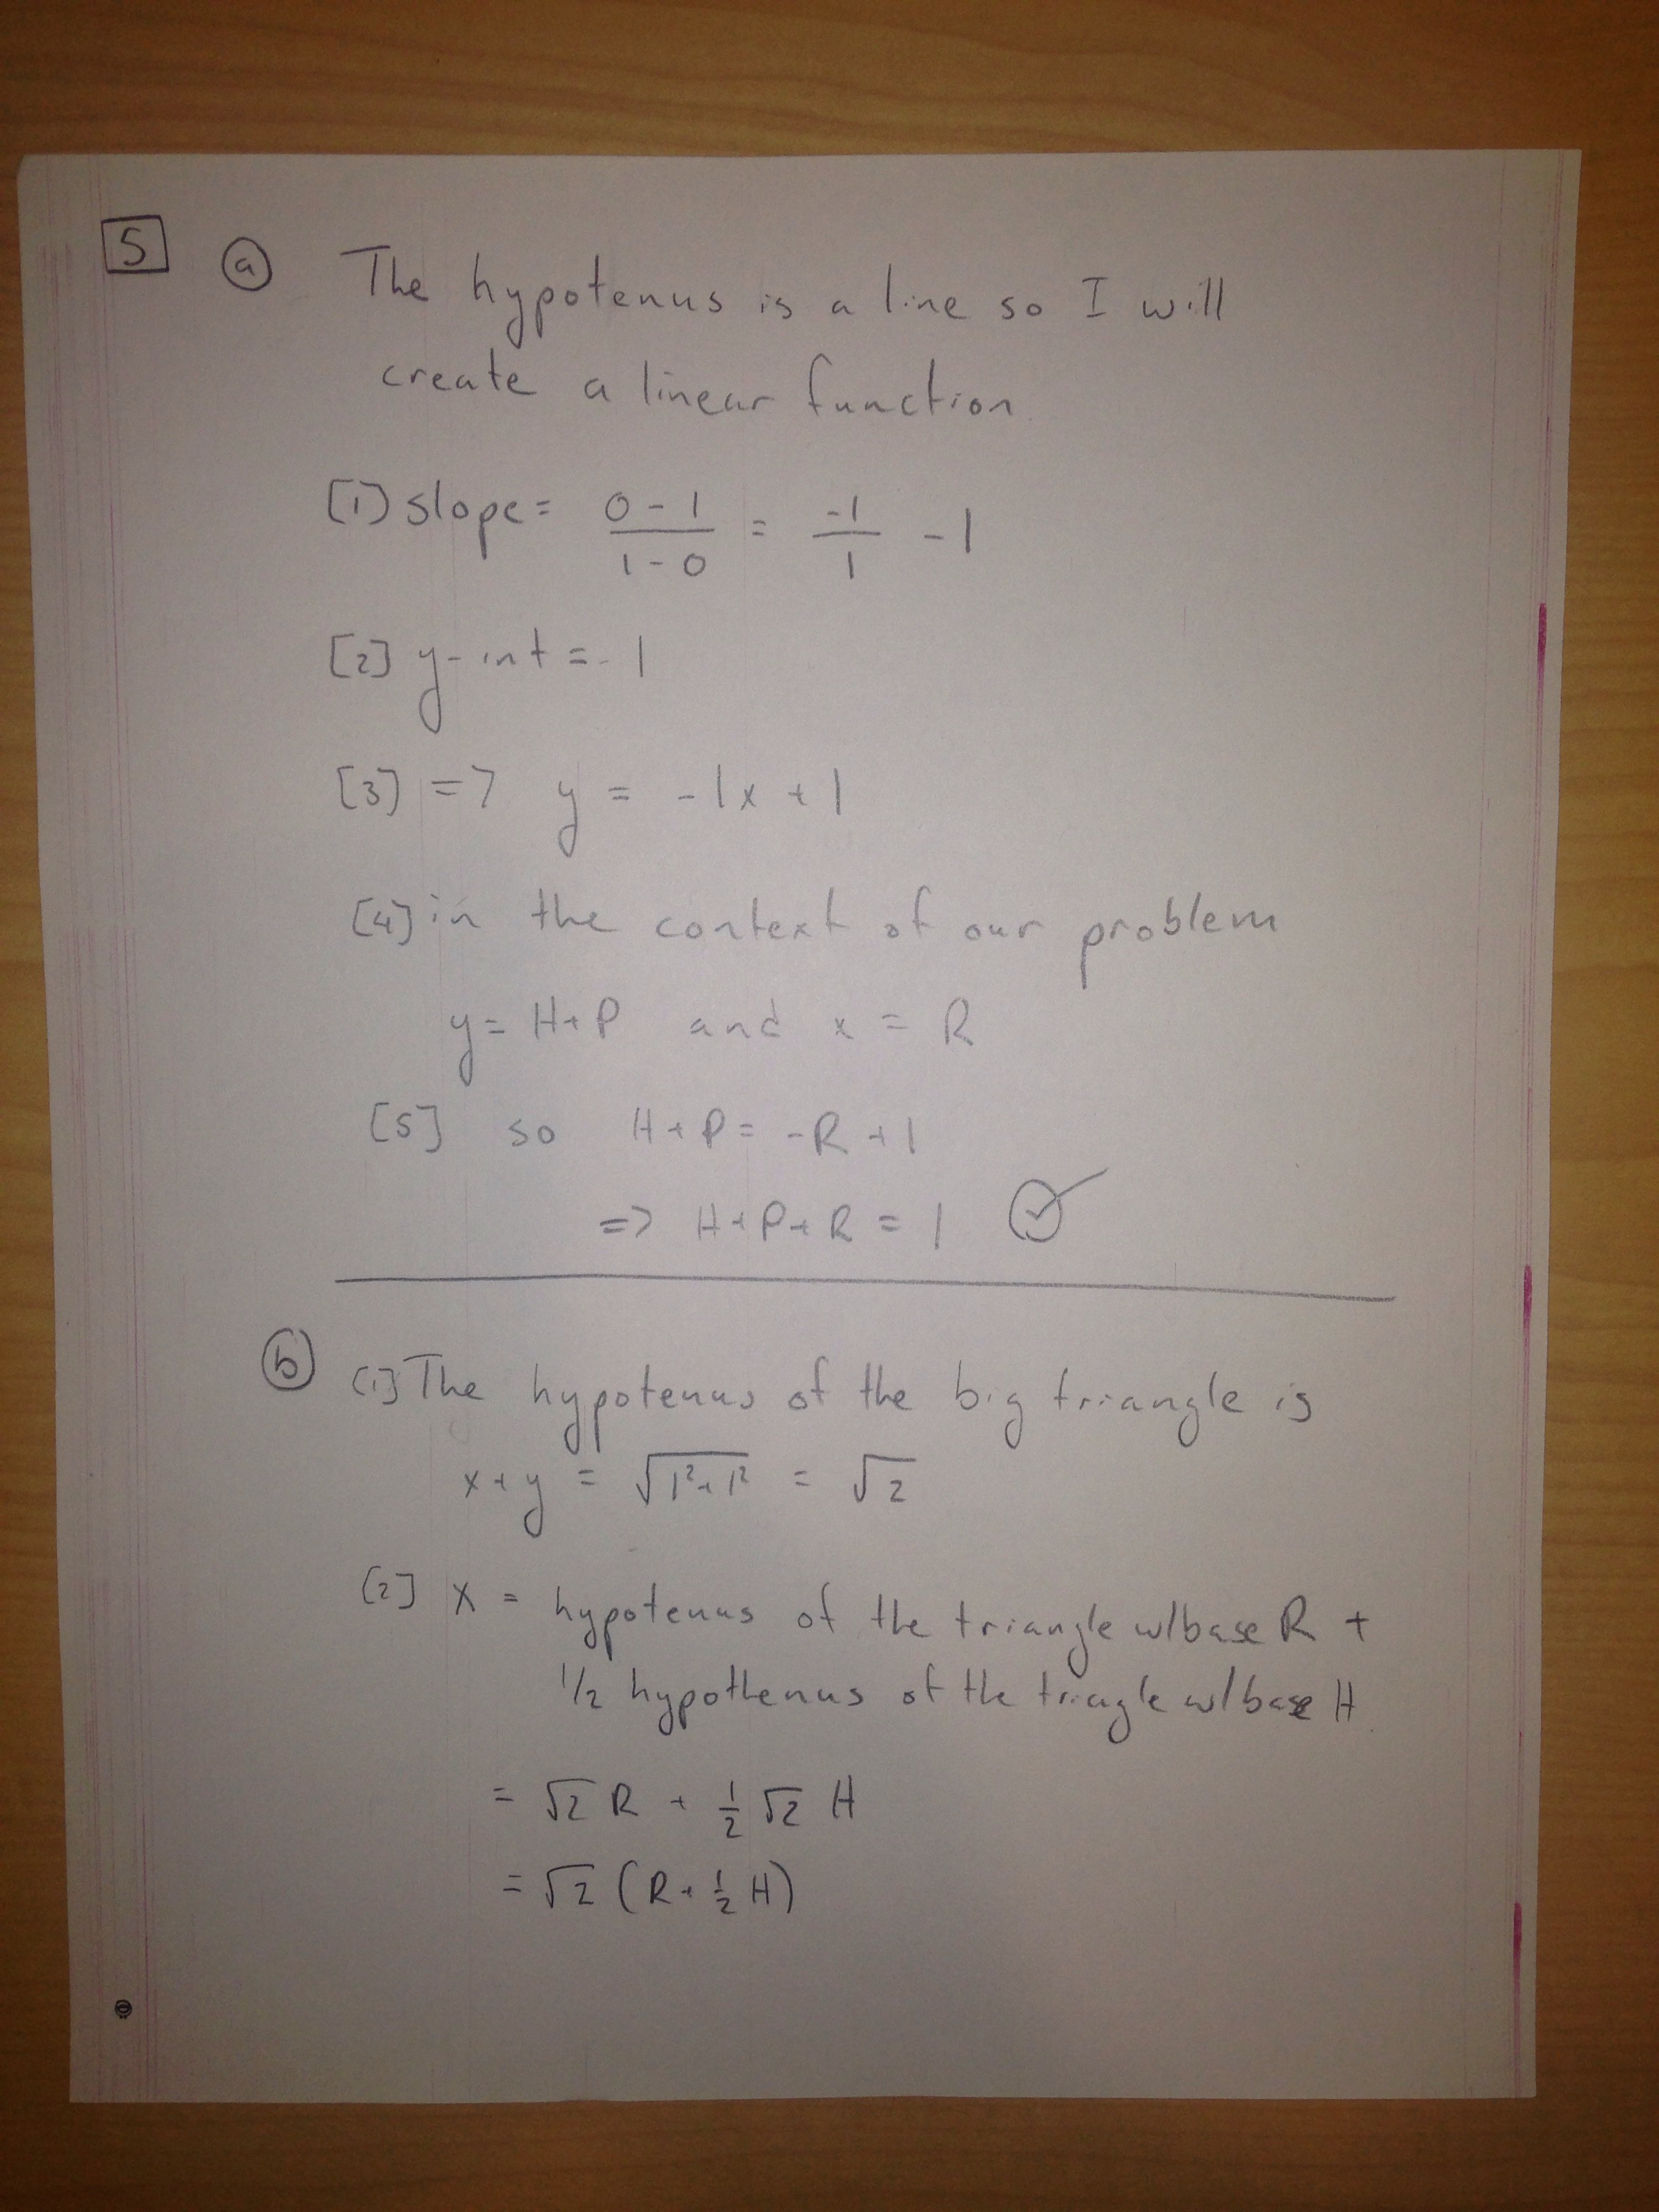

In [362]:
Image(filename= "/nas/Personal folders/Joaquin/Assignment_1/Question 5a.jpg", width=1000, height=300)

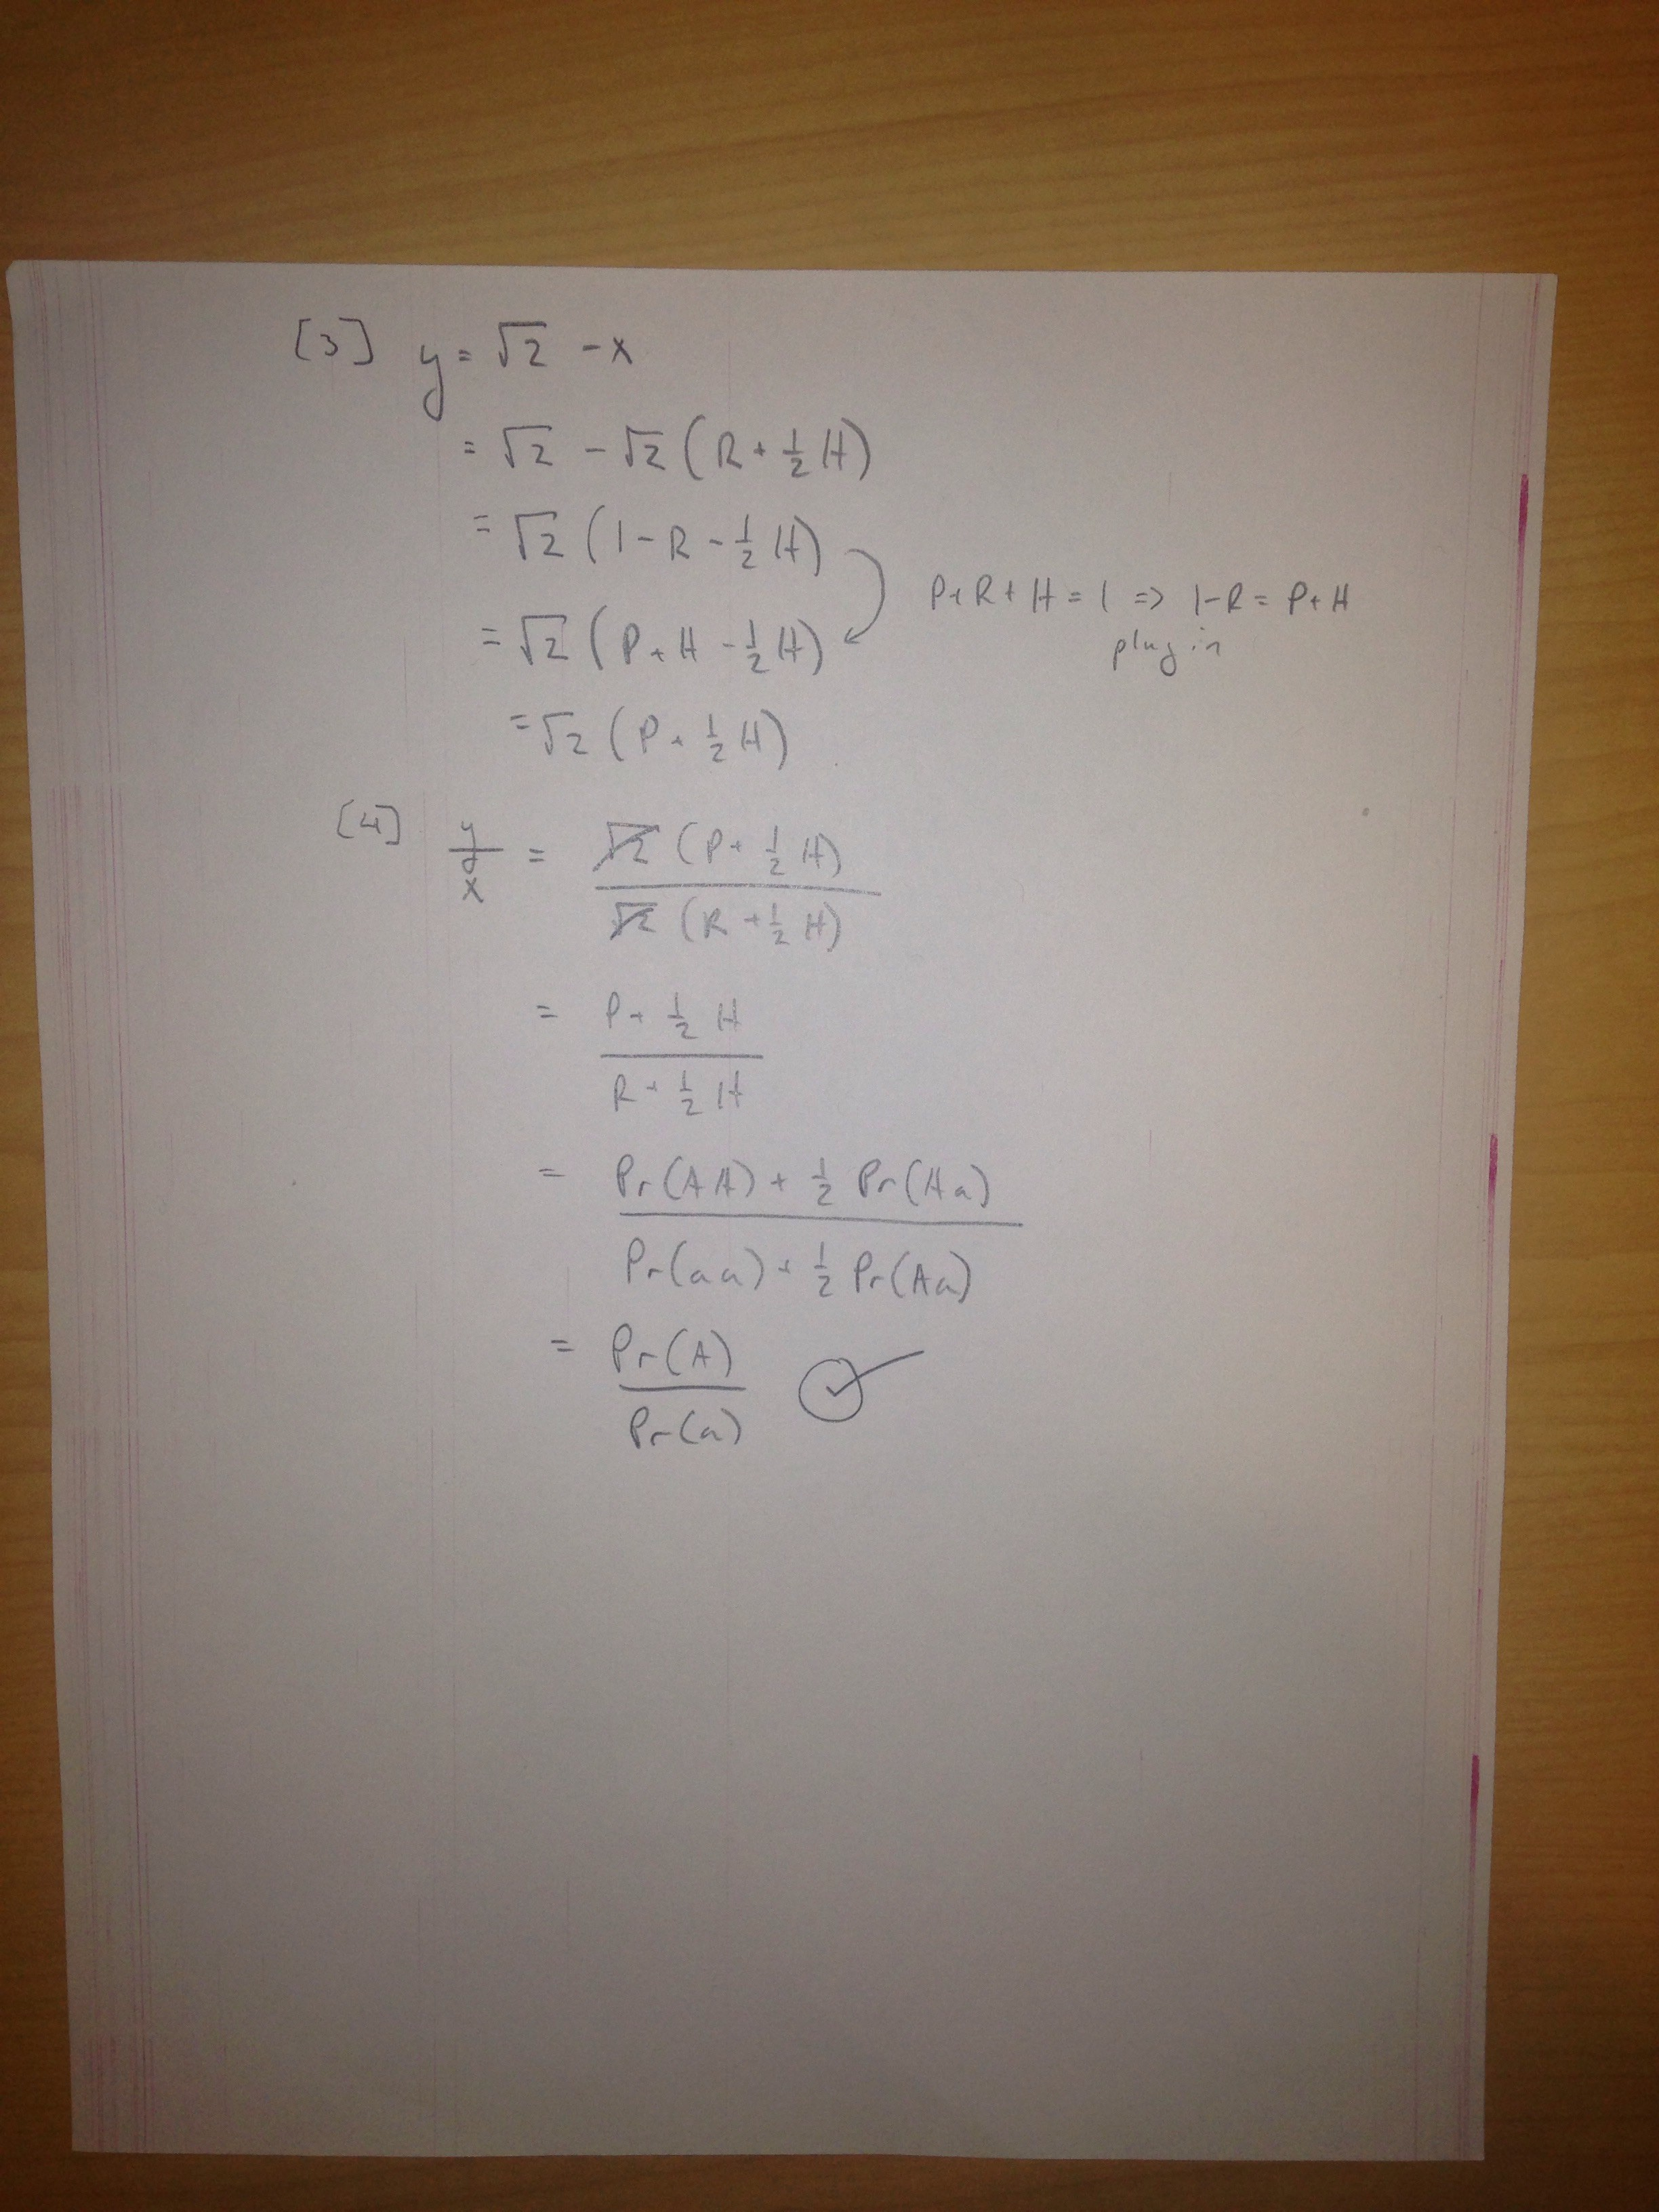

In [361]:
Image(filename= "/nas/Personal folders/Joaquin/Assignment_1/Question 5b.jpg", width=1000, height=300)

## Question 6: SNP matrices

For each of the 6 data-sets (SNP matrices with n individuals/rows, and m
sites/columns) 

(a) Determine if a perfect phylogeny exists or not. You have to write code to do this.



(50 pts. total)

### Helper Functions

In [20]:
from glob import glob
import string 
import copy
from itertools import product
import time

In [21]:
def load_snp_data(fn):
    """Load the snp data into an array (list of lists)"""
    snp_array = []
    with open(fn, 'r') as data:
        for line in data:
            row = []
            line = line.strip()
            for entry in line: 
                row.append(int(entry))
            snp_array.append(row)
    return snp_array
    # return pd.DataFrame(snp_array)#, columns = list(string.ascii_uppercase[0:len(snp_array[0])]))
    
def transpose_array(array):
    array = copy.deepcopy(array)
    t_array = []
    for column in range(len(array[0])):
        t_column = []
        for row in range(len(array)):
            t_column.append(array[row][column])
        t_array.append(t_column)
    return t_array

### Algorithmic Functions

In [22]:
def get_intersects(column_i, column_j):
    """
    Looking for mutations in column_j that intersect with 
    mutations in column_i.
    """
    intersects = []
    for index in range(len(column_i)):   
        if column_j[index] == 1 and column_i[index] == 1:
            intersects.append(index)
    return intersects        

In [23]:
def get_differences(column_i, column_j):
    """
    Looking for mutations in column_j not found in column_i.
    """    
    differences = []
    for index in range(len(column_i)):   
        if column_j[index] == 1 and column_i[index] == 0:
            differences.append(index)
    return differences        

In [24]:
def count_mutations(column):
    """
    Counting the number of mutations at a given site (column)."""
    mutations = 0
    for entry in column:
        if entry == 1:
            mutations += 1
    return mutations 

In [25]:
def is_perfect_phylo(t_array):
    
    column = 0 
    perfect_phylo = True
    num_columns = len(t_array)
    num_rows = len(t_array[0])
    while column < num_columns - 1:    


        message = 'column: {}'.format(column)
        column_i = t_array[column]
        column_j= t_array[column + 1]

        mutations = count_mutations(column_j)
        intersects = get_intersects(column_i, column_j)
        differences = get_differences(column_i, column_j)

        if len(intersects) == mutations:
            # column j is a subset. 
            column += 1

        elif len(differences) > 0 and len(intersects) == 0:
            # column j is not a subset and does not share 
            # any mutations with column i.
            column += 1

        elif len(differences) > 0 and len(intersects) > 0:
            # column j is only a partial subset of column i
            # so their intersection is not trivial and the 
            # perfect phylogeny is lost.
            perfect_phylo = False
            break


        message += ', mutations: {}, intersects: {}, differences: {}'.\
            format(mutations, intersects, differences)
        #time.sleep(1)
        #print message
        #print 
        
    return perfect_phylo

### Testing the Algorithm

#### Lecture Data

In [ ]:
lecture_data = load_snp_data('./lecture_data.txt')
lecture_data = [[1,1,1], [0,1,0], [1,0,0]]
t_array = transpose_array(lecture_data)
t_array.sort(reverse=True)


#### My cases

In [ ]:
case1 = [[1,1,1], [0,0,0]]
case2 = [[1,1,1], [1,0,0]]
case3 = [[1,1,0], [1,1,0]]
case4 = [[1,1,0], [1,0,1]]
case5 = [[1,1,0], [0,1,1]]
case6 = [[1,1,0], [0,0,1]]
cases = [case1, case2, case3, case4, case5, case6]
cases = [transpose_array(case) for case in cases]

In [ ]:
lecture_data = load_snp_data('./lecture_data.txt')
lecture_data = [[1,1,1], [0,1,0], [1,0,0]]
t_array = transpose_array(lecture_data)
t_array.sort(reverse=True)

In [ ]:
for case in cases:
    t_array = transpose_array(case)
    t_array.sort(reverse=True)
    print is_perfect_phylo(t_array)

### Running on Data

In [85]:
#evals = []
fns = glob('./a1data*.txt')
fns.sort()
intervals = [10**2, 100**2, 1000**2, 1000**2, 10000**2, 10000**2]

In [364]:
times = []
start = time.time()
end = time.time()

for fn in fns:
    print 'fn: {}'.format(fn)
    snp_array = load_snp_data(fn)
    
    start = time.time()
    #print 'rows: {}, columns: {}'.format(len(snp_array), len(snp_array[0]))
    t_array = transpose_array(snp_array)
    t_array.sort(reverse=True)
    evals.append(is_perfect_phylo(t_array))
    
    end = time.time()
    times.append(end - start)

In [341]:
for matrix in range(1, 7):
    print 'a1data{} a perfect phylogeny? {}'.format(matrix, evals[matrix - 1])

a1data1 a perfect phylogeny? True
a1data2 a perfect phylogeny? True
a1data3 a perfect phylogeny? True
a1data4 a perfect phylogeny? False
a1data5 a perfect phylogeny? True
a1data6 a perfect phylogeny? False


### Algorithm Design + Psuedocode 

Design:

To determine a perfect phylogeny I started by sorting the SNP array by column.
Once the column is sorted then you can iterate from column to column. When there 
is perfect phylogeny, column i + 1 should either be a subset of column i or column i + 1 does not over lap with column i at all (intersection is the null set). 

Psuedocode:

snp_array = read and parse data
while column is not the second to last column:
    if column i + 1 is a subset of column i:
        continue
    if column i + 1 intersects partially with column i:
        there is no perfect phylogeny 

### Plotting the Running Time

(b) Plot the running time of your code as a function of n · m. For full credit, it should scale
linearly. Describe the key ideas using pseudo-code, and use a log-log plot so that all
points are seen and show guide lines with slopes 1 and 2, to argue that you are scaling
linearly.
- log-log plot
- guide-lines with slope 1 and another with slope  2
- argue that it's linear

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
t = np.arange(0.01, 20.0, 0.01)

In [87]:
nm = []
nm2 = []
for i in range(0, 10000, 10):
    for j in range(0, 10000, 10):
        val = i * j
        nm.append(val)
        nm2.append(val**2)

Green = slope 2
Blue = slope 1
Red = Running Time


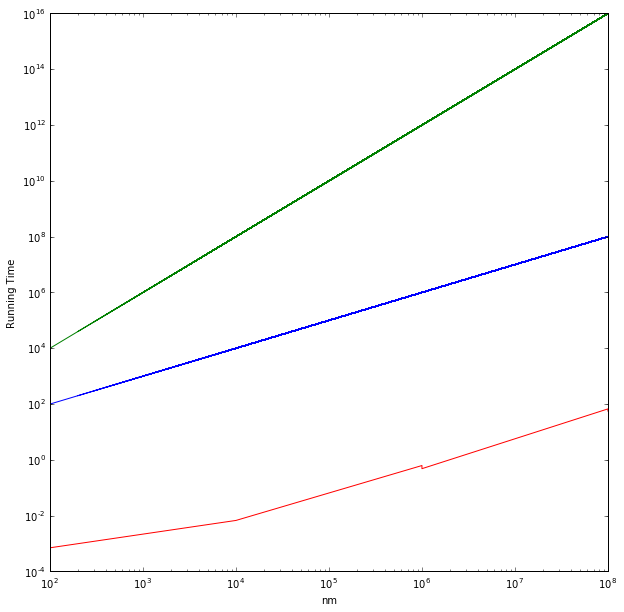

In [363]:
fig = plt.figure(figsize=(10,10))
plt.loglog(nm, nm, basex=10, basey=10)
plt.loglog(nm, nm2, basex=10)
plt.loglog(intervals, times)
ax = fig.get_axes()[0]
ax.set_ylabel('Running Time')
ax.set_xlabel('nm')
plt.legend(loc='upper left')
print 'Green = slope 2\nBlue = slope 1\nRed = Running Time'

## Question 7: Mapping Ancestry

Given the mtDNA genotypes of individuals sampled at the following locations on
the globe (Figure 2), give your best guess for the migration routes.

(10 pts.)

Design:
According to the infinite sites assumption mutations have only happen at most once. So my idea is that by counting 
the number of mutations an individual has we can then trace their migration going from 1 --> 2 --> 3 --> 4 while
assuring that the migrations are consistent with thee locations of mutations between source and destination populations. 

In [184]:
snp_dataframe = pd.read_table('./a1globedata.txt', sep='   ', skiprows=0)

snp_array = snp_dataframe.values.tolist()
t_array = transpose_array(snp_array)
t_array.sort(reverse=True)
new_array = pd.DataFrame(t_array)
new_array = new_array.transpose()

new_array.index = snp_dataframe.index.tolist()
new_array.columns = snp_dataframe.columns.tolist()

/frazer01/home/joreyna/anaconda2/envs/cie/lib/python2.7/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [215]:
new_array

a  b  c  d  e  f  g  h  i  j  k  l  m  n  o
1   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
2   1  1  1  1  0  0  0  0  0  0  0  0  0  0  0
3   1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
4   1  1  0  0  0  0  1  1  0  0  0  0  0  0  0
5   1  1  0  0  0  0  1  1  1  1  0  0  0  0  0
6   1  1  0  0  0  0  1  1  1  0  1  0  0  0  0
7   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
8   1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
9   1  0  0  0  0  0  0  0  0  0  0  1  1  0  0
10  1  1  0  0  0  0  1  1  1  0  0  0  0  0  0
11  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0
12  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
13  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
14  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
15  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
16  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0

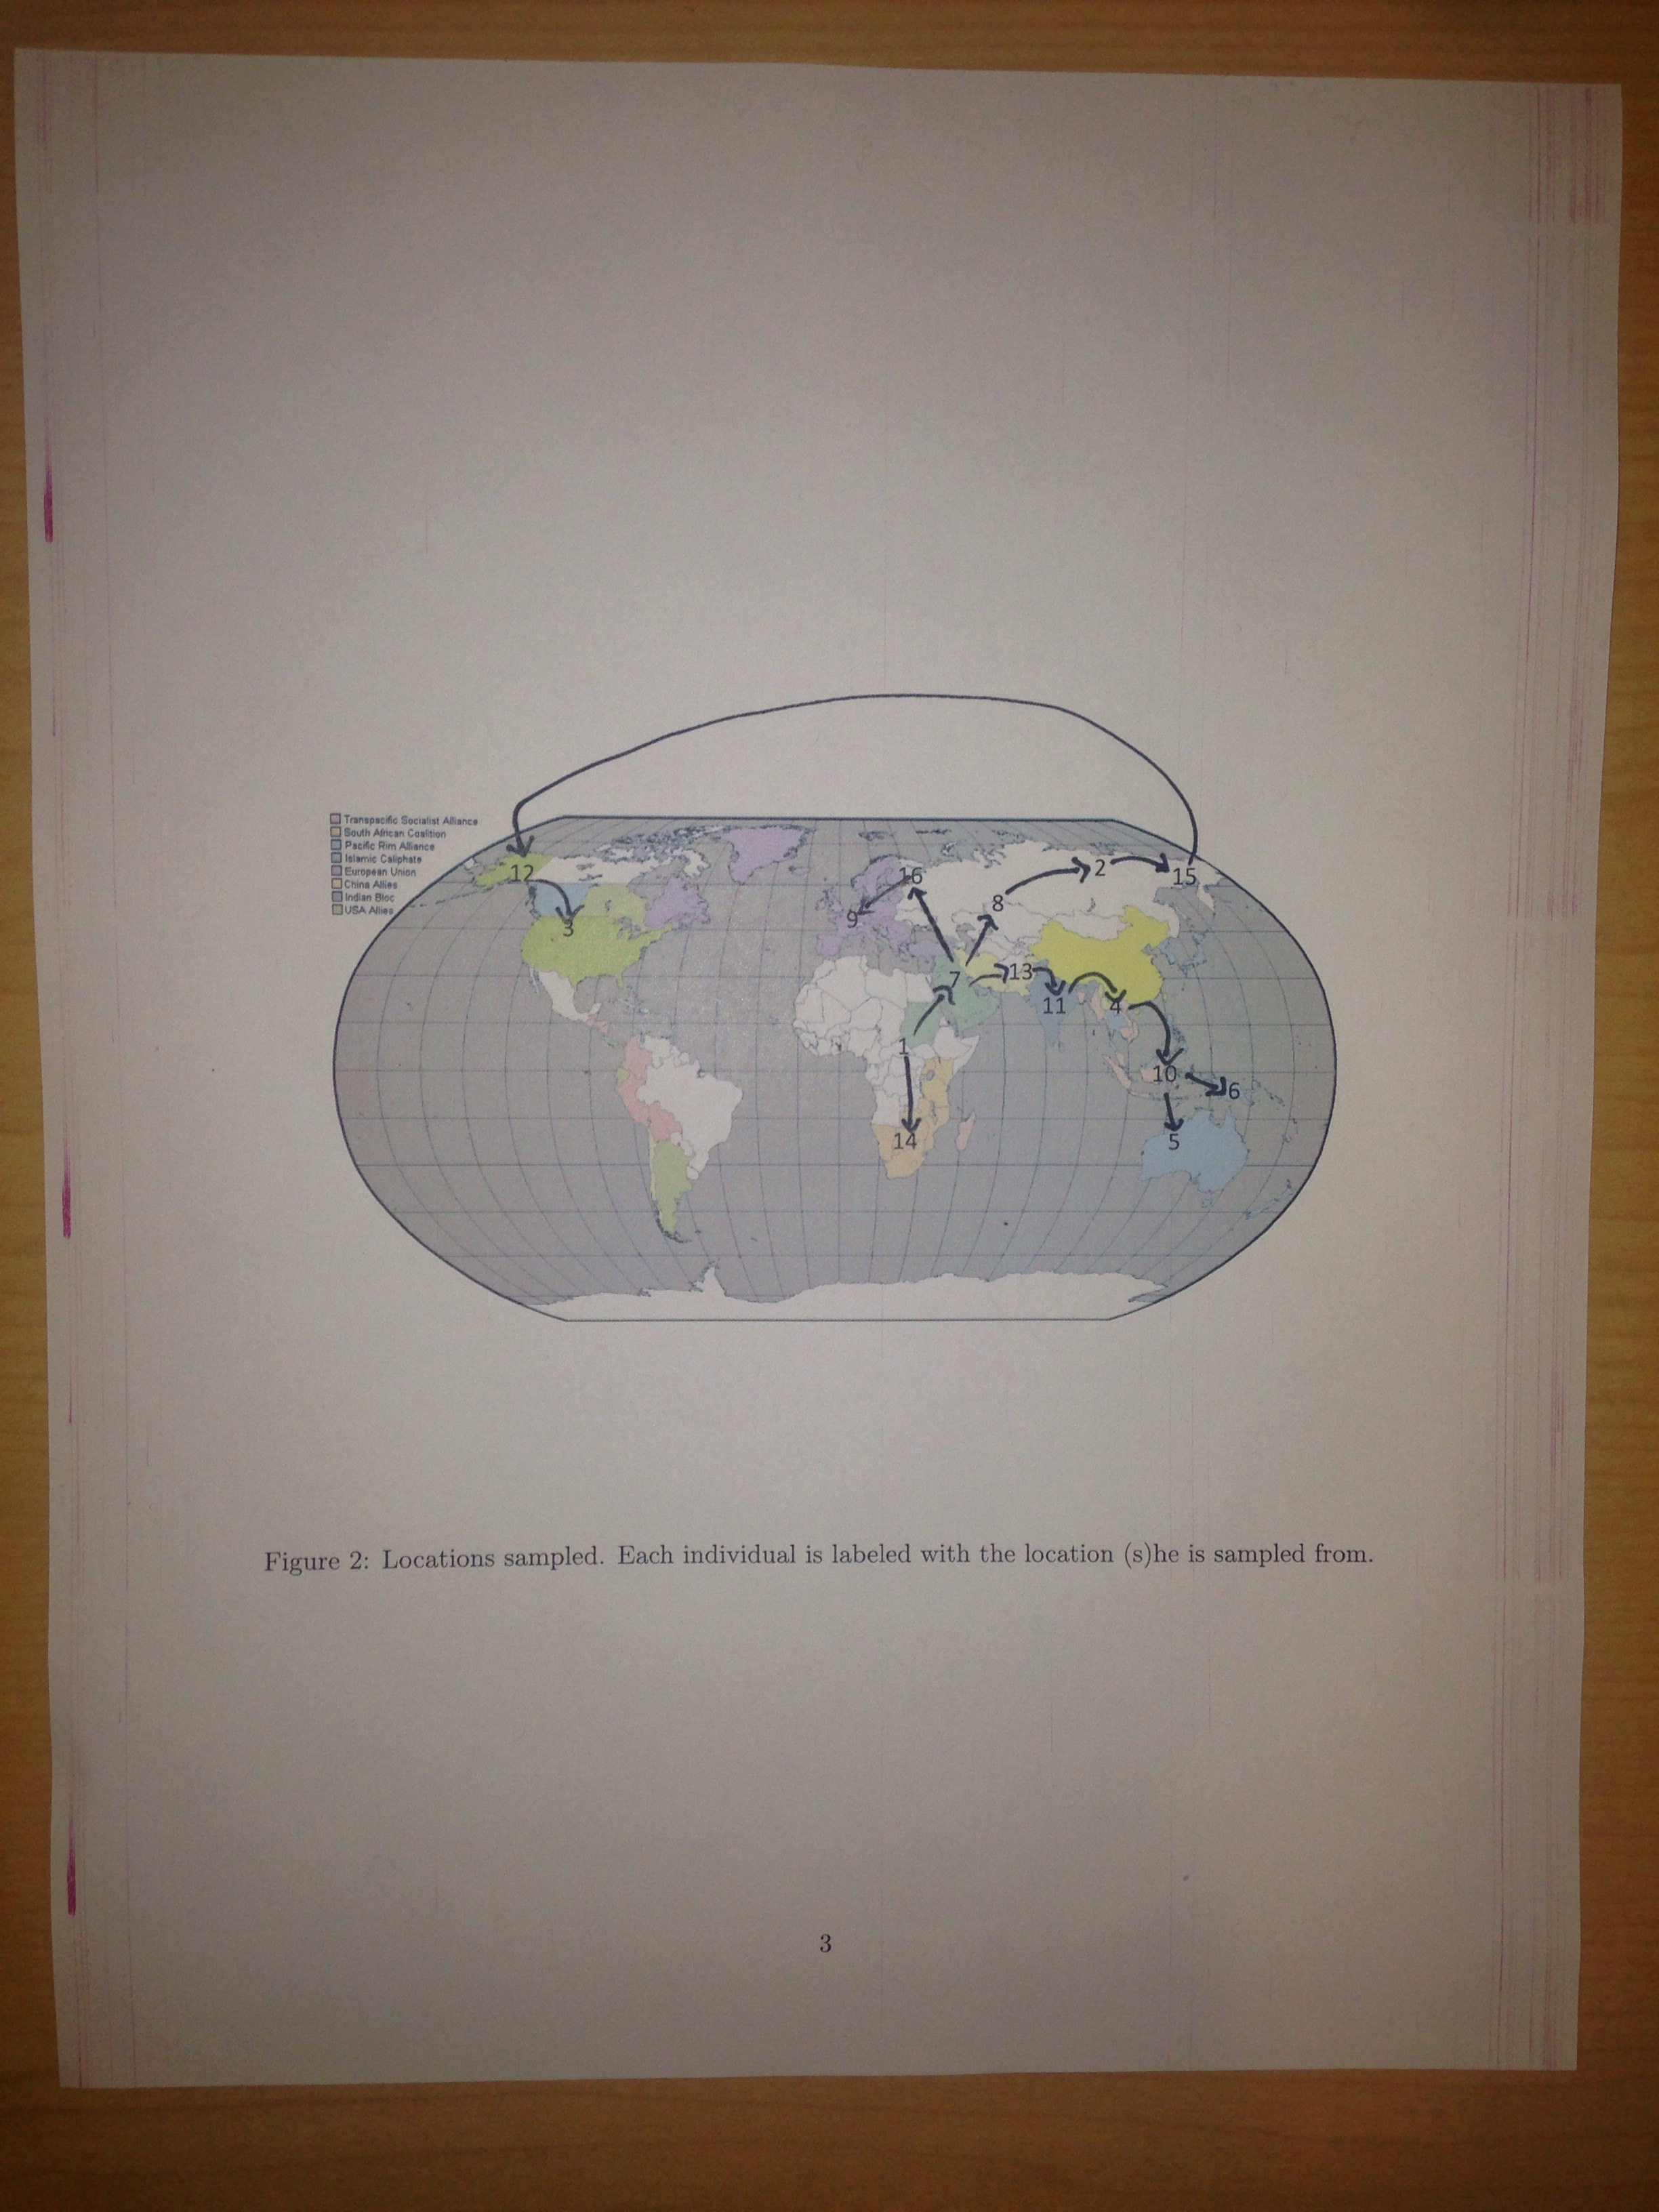

In [360]:
Image(filename= "/nas/Personal folders/Joaquin/Assignment_1/Question 7.jpg", width=1000, height=300)